# Data Processing

In [1]:
import csv

In [2]:
with open("password_trainv3.csv") as csv_file:
    reader = csv.reader(csv_file)
    char_ststistics = {}
    for i, row in enumerate(reader):
        if(i == 0): continue
        for c in row[1]:
            if c in char_ststistics: char_ststistics[c] += 1
            else: char_ststistics[c] = 1

In [3]:
values = []
alphapet = ''
for c in sorted(char_ststistics):
    print(c, char_ststistics[c])
    values.append(char_ststistics[c])
    alphapet += c

print(f'min value {min(values)}\nmax value {max(values)}')
print (alphapet)

! 66
" 72
# 114
$ 99
% 66
& 63
' 84
( 54
) 66
* 96
+ 54
, 72
- 84
. 81
/ 57
0 114
1 120
2 114
3 105
4 138
5 111
6 114
7 99
8 90
9 105
: 57
; 69
< 75
= 84
> 72
? 66
@ 60
A 54
B 78
C 84
D 75
E 84
F 69
G 84
H 54
I 87
J 78
K 39
L 72
M 69
N 78
O 75
P 75
Q 66
R 81
S 81
T 99
U 42
V 69
W 96
X 75
Y 69
Z 72
[ 60
\ 63
] 87
^ 84
_ 54
` 81
a 93
b 69
c 63
d 96
e 60
f 72
g 87
h 87
i 81
j 66
k 66
l 45
m 111
n 114
o 63
p 72
q 69
r 69
s 48
t 69
u 60
v 63
w 81
x 60
y 66
z 63
{ 57
| 63
} 81
~ 60
min value 39
max value 138
!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~


# DataSet.py

In [4]:
from torch.utils.data import Dataset, sampler, DataLoader
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import csv
from PIL import Image
import random

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
class Passwords_data(Dataset):
    def __init__ (self, csv_Path, imgs_path, transformers = None):
        with open(csv_Path, 'r') as csv_file:
            # images names and labels in matching indices
            reader = csv.reader(csv_file)
            self.imgs = []
            self.lables = []
            for i, row in enumerate(reader):
                if i == 0: continue
                self.imgs.append(row[0])
                self.lables.append(row[1])
                
            self.imgs_file = imgs_path
            self.transformers = transformers
    
    def __getitem__(self, index):
        # image
        img_path = self.imgs_file + '/' + self.imgs[index]
        img = Image.open(img_path).convert('L')
        #print(img.size)
        
        # image augmentation
        if self.transformers != None:
            img = self.transformers(img)
        img = transforms.ToTensor()(img)
        # lable
        lable = self.lables[index]
        
        return (img_path, img, lable)
    
    def __len__(self):
        return len(self.imgs)

In [6]:
class ResizeNormalize (object):
    def __init__(self, img_size):
        self.img_size = img_size # imgH, imgW
    
    def __call__(self, img):
        img = transforms.Resize(size=self.img_size)(transforms.ToPILImage()(img))
        img = transforms.ToTensor()(img)
        img.sub_(0.5).div_(0.5) # normalize gray scale
        return img

In [7]:
class AlignBatch(object):
    def __init__(self, imgH = 32, imgW = 100, keep_ratio = True, min_ratio = 1, padding = False):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio = keep_ratio
        self.min_ratio = min_ratio
        self.padding = padding
        
    def __call__(self, batch):
        img_paths, imgs, lables = zip(*batch)
        imgH = self.imgH
        imgW = self.imgW
        
        if(self.keep_ratio):
            max_ratio = 0
            for img in imgs:
                #print(img.shape)
                _, h, w = img.shape
                if max_ratio < (w/h): max_ratio = (w/h)
            if self.padding:
                imgs_padded = []
                for i, img in enumerate(imgs):
                    _, h, w = img.shape
                    w_new = h * max_ratio
                    pad = int((w_new - w) / 2)
                    #print(img.shape)
                    imgs_padded.append(F.pad(img, (pad, pad), "constant"))
                imgs = imgs_padded
            
            imgW = int(max_ratio * imgH)
            
        resizer = ResizeNormalize((imgH, imgW))
        imgs = [resizer(img).unsqueeze(0) for img in imgs]
        imgs = torch.cat(imgs, 0)
        return img_paths, imgs, lables
                    

In [8]:
class MatchingSampler(sampler.Sampler):
    
    def __init__ (self, data_source, batch_size):
        self.data_source = data_source
        self.number_sampels = len(data_source)
        self.batch_size = batch_size
        
    def __iter__ (self):
        n_batches = len(self)//self.batch_size
        tail = len(self) % self.batch_size
        index = torch.LongTensor(len(self)).fill_(0)
        for i in range(n_batches):
            random_start = random.randint(0, len(self)-self.batch_size)
            b_indx = random_start + torch.arange(0, self.batch_size)
            index[i*self.batch_size : (i+1) * self.batch_size] = b_indx
        if tail:
            random_start = random.randint(0, len(self)-tail)
            b_indx = random_start + torch.arange(0, tail-1)
            index[n_batches * self.batch_size:] = b_indx
            
        return iter(index)
        
    def __len__(self):
        return self.number_sampels

torch.Size([1, 32, 228])


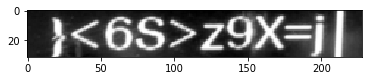

}<6S>z9X=j|
torch.Size([1, 32, 228])


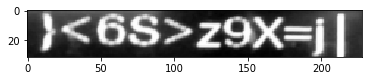

}<6S>z9X=j|
torch.Size([1, 32, 228])


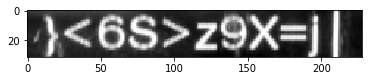

}<6S>z9X=j|
torch.Size([1, 32, 228])


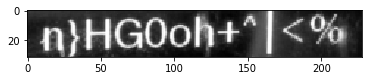

n}HG0oh+^|<%


In [9]:
dataset = Passwords_data('password_trainv3.csv', 'train_passwordv3')

sampler = MatchingSampler(dataset, 4)
align = AlignBatch()
dataloder = DataLoader(dataset, batch_size=4, collate_fn=align, shuffle= False)

img_pathes, imgs, lables = next(iter(dataloder))

for sample in zip(img_pathes, imgs, lables):
    #print(sample)
    img_path, img, lable = sample
    print(img.shape)
    plt.imshow(img.squeeze(0).numpy(), cmap='gray')
    plt.show()
    print(lable)

# Model

In [10]:
import torch.nn as nn

In [11]:
class BiDrictionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BiDrictionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    
    def forward(self, input):
        recurrent, _ = self.rnn(input)
        t_steps, b_size, h_num = recurrent.shape
        recurrent = recurrent.view(t_steps*b_size, h_num) # prepare the linear layer input
        
        output = self.embedding(recurrent)
        output = output.view(t_steps, b_size, -1)
        
        return output

In [ ]:
'''
class ConvLayer(nn.Module):
    def __init__(self, inFilt, outFilt, kerSiz, padSiz, strideSiz, b_n = False):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(inFilt, outFilt, kerSiz, padSiz, strideSiz)
        self.relu = nn.ReLU(inplace=True)
    
    def
'''

In [12]:
class CRNN(nn.Module):
    def __init__(self, imgH, inChannal, nClasses, nHidden, nLSTMs = 2):
        super(CRNN, self).__init__()
        assert imgH == 32 , 'the image input hight must be 32'
        
        ks = [3, 3, 3, 3, 3, 3, 2] # kernal Size
        ps = [1, 1, 1, 1, 1, 1, 0] # padding
        ss = [1, 1, 1, 1, 1, 1, 1] # stride
        fn = [64, 128, 256, 256, 512, 512, 512] # filters number
        
        cnn = nn.Sequential()
        
        
        def conv_layer(layNum, b_n = False):
            nIn = inChannal if layNum == 0 else fn[layNum-1]
            nOut = fn[layNum]
            # Conv Layer
            cnn.add_module(f'conv{layNum}', nn.Conv2d(nIn, nOut, ks[layNum], ss[layNum], ps[layNum]))
            # btach normalization
            if b_n:
                cnn.add_module(f'batchnorm{layNum}', nn.BatchNorm2d(nOut))
            # non Linearity (ReLU)
            cnn.add_module(f'relu{layNum}', nn.ReLU(inplace=True))
            
        # Cnn Arch
        conv_layer(0)
        cnn.add_module(f'pooling{0}', nn.MaxPool2d(2, 2))  # 64 x 16
        conv_layer(1)
        cnn.add_module(f'pooling{1}', nn.MaxPool2d(2, 2))  # 128 x 8
        conv_layer(2, b_n=True)
        conv_layer(3)
        # the irregular shape of stride and padding beacause of the shape of some char like (i, ..)
        cnn.add_module(f'pooling{2}', nn.MaxPool2d((2, 2), (2, 1), (0, 1))) # 256 x 4
        conv_layer(4, b_n=True)
        conv_layer(5)
        cnn.add_module(f'pooling{3}', nn.MaxPool2d((2, 2), (2, 1), (0, 1))) # 512 x 2
        conv_layer(6, b_n=True) #  512 x 1

        self.cnn = cnn

        # Rnn Arch
        rnn = nn.Sequential(
            BiDrictionalLSTM(512, nHidden, nHidden),
            BiDrictionalLSTM(nHidden, nHidden, nClasses)
        )

        self.rnn = rnn
        
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input):
        # cnn pass
        conv = self.cnn(input)
        b, c, h, w = conv.shape
        
        assert h == 1, 'the hight after cnn must equal 1'
        
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1) # sequance, batch, features
        
        # rnn pass 
        rnn = self.rnn(conv)
        
        output = self.softmax(rnn)
        
        return output


In [ ]:
crnn = CRNN(32, 1, 37, 256)

In [ ]:
crnn.load_state_dict(torch.load('crnn.pth'))

In [ ]:
# model state dict
st = crnn.state_dict()
for name in st:
    print(name)

In [ ]:
# checkpoint state dic
st = torch.load('crnn.pth')
for name,k in st.items():
    print(name)

# Utilties

## Logger

In [13]:
import tensorflow as tf


class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def list_of_scalars_summary(self, tag_value_pairs, step):
        """Log scalar variables."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value) for tag, value in tag_value_pairs])
        self.writer.add_summary(summary, step)

## Label String Convertion

In [14]:
class strLabelConverter(object):
    """Convert between str and label.

    NOTE:
        Insert `blank` to the alphabet for CTC.

    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.

        Args:
            text (str or list of str): texts to convert.

        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.abc.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.

        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.

        Raises:
            AssertionError: when the texts and its length does not match.

        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t]), [i - 1 for i in t]
            else:
                char_list = []
                lables_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                        lables_list.append(t[i] - 1)
                return ''.join(char_list), lables_list
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            lables = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                text, lable = self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw)
                texts.append(text)
                lables.append(lable)
                index += l
            return texts, lables

# Training

In [15]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import PIL
import time
import collections

import os

In [16]:
os.makedirs('checkpoints', exist_ok=True)

## Test Tranforms

In [ ]:
train_transforms = transforms.Compose([transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5)])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=0, translate=(.03,.03))])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=0, scale=(.95,1.05))])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=0, shear=20)])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(degrees=3, expand=True), 
                                       transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5)])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomPerspective()])

In [ ]:
dataset = Passwords_data('password_trainv3.csv', 'train_passwordv3', transformers=train_transforms)

sampler = MatchingSampler(dataset, 4)
align = AlignBatch()
dataloder = DataLoader(dataset, batch_size=4, collate_fn=align, shuffle= True)

img_pathes, imgs, lables = next(iter(dataloder))
#print(converter.encode(lables))

for sample in zip(img_pathes, imgs, lables):
    #print(sample)
    img_path, img, lable = sample
    print(img.shape)
    plt.imshow(img.squeeze(0).numpy(), cmap='gray')
    plt.show()
    print(lable)

## continue training

In [17]:
# training variables 
epochs_num = 100
batch_size = 16
cuda = torch.cuda.is_available()
n_workers = 4
nClasses = len(char_ststistics) + 1
inChannels = 1
imgH = 32
nHidden = 256
lr = .001
test_display = 4
val_each = 1
use_pretrained = True
pre_trained = 'crnn.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'detect cuda device? {cuda}')
print(f'number of classes id {nClasses-1} + blank')

detect cuda device? True
number of classes id 94 + blank


In [18]:
train_transforms = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms.RandomAffine(degrees=0, translate=(.03,.03)),
            transforms.RandomAffine(degrees=0, scale=(.95,1.05)),
            transforms.RandomAffine(degrees=0, shear=20),
            transforms.RandomRotation(degrees=3, expand=True)]),
        transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3)],  p=0.5)])

In [19]:
train_dataset = Passwords_data('password_train.csv', 'train_passwordv3', transformers=train_transforms)

#sampler = MatchingSampler(dataset, batch_size)
align = AlignBatch()
train_dataloder = DataLoader(train_dataset, batch_size=batch_size, collate_fn=align, 
                       shuffle= True, num_workers=n_workers)

In [20]:
val_dataset = Passwords_data('password_train.csv', 'train_passwordv3')

#sampler = MatchingSampler(dataset, batch_size)
align = AlignBatch()
val_dataloder = DataLoader(train_dataset, batch_size=batch_size, collate_fn=align, 
                       shuffle= True, num_workers=n_workers)

In [21]:
converter = strLabelConverter(alphapet, ignore_case=False)
criterion = nn.CTCLoss()

In [22]:
def weights_init(m):
    class_name = m.__class__.__name__
    if class_name.find('conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [24]:
crnn = CRNN(imgH, inChannels, nClasses, nHidden)
crnn.apply(weights_init)
if use_pretrained :
    model_dict = crnn.state_dict() # state of the current model
    pretrained_dict = torch.load(pre_trained) # state of the pretrained model
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k != 'rnn.1.embedding.weight' and k != 'rnn.1.embedding.bias'} # remove the classifier from the state
    classifier_dict = {k: v for k, v in model_dict.items() if k == 'rnn.1.embedding.weight' or k == 'rnn.1.embedding.bias'} # get the classifier weight from new model
    pretrained_dict.update(classifier_dict) # update without classifier
    crnn.load_state_dict(pretrained_dict)
    
print(crnn)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

In [25]:
if cuda :
    crnn = crnn.to(device)
    criterion = criterion.to(device)

In [26]:
optimizer = optim.Adam(crnn.parameters(), lr=lr)

In [27]:
# define logger file
os.makedirs('logs', exist_ok=True)
logger = Logger('logs')

In [28]:
def train(model, criterion, optimizer, logger, train_dataloder, batch_size, epoch_num):
    model.train()
    epoch_loss = 0
    samples_num = 0
    
    for batch_i, (_, imgs, targets) in enumerate(train_dataloder):
        batches_done = len(train_dataloder) * epoch_num + batch_i
        samples_num += imgs.shape[0]
        
        # move to device and create variables
        imgs = Variable(imgs.to(device))
        targets, lenghts = converter.encode(targets)
        targets = Variable(targets.to(device), requires_grad=False)
        t_lens = Variable(lenghts, requires_grad=False)
        
        # pass to the network
        preds = model(imgs)
        preds_size = Variable(torch.IntTensor([preds.shape[0]] * imgs.shape[0]))
        
        # loss
        #print(preds_size.shape)
        loss = criterion(preds, targets.cpu(), preds_size, t_lens)
        epoch_loss += loss * imgs.shape[0]
        logger.scalar_summary('loss_batches', loss, batches_done)
        print(f'Epoch {epoch_num}, Batch {batch_i}/{len(train_dataloder)} : Loss = {loss}')
        
        # optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    epoch_loss /= samples_num
    logger.scalar_summary('loss_epochs', epoch_loss, epoch_num)
    
    return epoch_loss

In [29]:
def val(model, criterion, logger, val_dataloder, epoch_num, batch_size=16, max_itre=100):
    model.eval()
    
    nCorrect_words = 0
    #nCorrect_chars = 0
    val_loss = 0
    samples_num = 0
    
    for batch_i, (_, imgs, targets) in enumerate(val_dataloder):
        samples_num += imgs.shape[0]
        
        # move to device and create variables
        imgs = Variable(imgs.to(device), requires_grad=False)
        targets_encoded, lenghts = converter.encode(targets)
        targets_encoded = Variable(targets_encoded.to(device), requires_grad=False)
        t_lens = Variable(lenghts, requires_grad=False)
        
        with torch.no_grad():
            # pass to the network
            preds = model(imgs)
            preds_size = Variable(torch.IntTensor([preds.shape[0]] * imgs.shape[0]))

            # loss
            loss = criterion(preds, targets_encoded.cpu(), preds_size, t_lens)
            val_loss += loss * imgs.shape[0]
            
            # get the nework prediction
            _, preds = preds.max(2)
            preds = preds.transpose(1,0).contiguous().view(-1)
            words_preds, lables_preds = converter.decode(preds, preds_size)
            
            for word_pred, target in zip(words_preds, targets):
                if word_pred == target:
                    nCorrect_words += 1
    
    # display some of the network prediction
    row_preds, _ = converter.decode(preds, preds_size, raw=True)[:test_display]

    for row_pred, word_pred, gt in zip(row_preds, words_preds, targets):
        print(f'{row_pred} => {word_pred}, Ground Truth is {gt}')
    
    #compute loss and accurcy
    word_accurcy = nCorrect_words / samples_num
    val_loss /= samples_num
    logger.scalar_summary('val_loss', val_loss, epoch_num)
    logger.scalar_summary('val_WordAccurcy', word_accurcy, epoch_num)
    
    return val_loss, word_accurcy

In [30]:
best_acc = 0
for epoch in range(epochs_num):
    
    tick = time.time()
    train_loss = train(crnn, criterion, optimizer, logger, 
                       train_dataloder, batch_size, epoch)
    tock = time.time()
    
    print(f'Epoch {epoch} finished in {(tock - tick) / 60} minutes')
    print(f'Epoch {epoch} training_loss = {train_loss}')
    
    if epoch % val_each == 0:
        val_loss, val_accurcy = val(crnn, criterion, logger, val_dataloder,
                                    epoch, batch_size)
        print(f'Epoch {epoch} val_loss = {val_loss}, word_accuracy = {val_accurcy}')
            
        # save best checkpoint
        if best_acc <= val_accurcy:
            best_acc = val_accurcy
            checkpoint = {'input_hight':32,
                          'output_size':len(alphapet)+1,
                          'alphapet':alphapet,
                          'train_transforms':train_transforms,
                          'optim_dic':optimizer.state_dict(),
                          'state_dic':crnn.state_dict(),
                          'epoch':epoch
                         }
            torch.save(checkpoint,'checkpoints/best_checkpoint.pth')
    
    # save last epoch
    checkpoint = {'input_hight':32,
                  'output_size':len(alphapet)+1,
                  'alphapet':alphapet,
                  'train_transforms':train_transforms,
                  'optim_dic':optimizer.state_dict(),
                  'state_dic':crnn.state_dict(),
                  'epoch':epoch
                 }
    torch.save(checkpoint,'checkpoints/last_checkpoint.pth')
            

Epoch 0, Batch 0/32 : Loss = 19.610260009765625
Epoch 0, Batch 1/32 : Loss = 21.16632652282715
Epoch 0, Batch 2/32 : Loss = 19.838205337524414
Epoch 0, Batch 3/32 : Loss = 19.917219161987305
Epoch 0, Batch 4/32 : Loss = 20.068241119384766
Epoch 0, Batch 5/32 : Loss = 18.35588264465332
Epoch 0, Batch 6/32 : Loss = 16.09850311279297
Epoch 0, Batch 7/32 : Loss = 14.059656143188477
Epoch 0, Batch 8/32 : Loss = 13.752017974853516
Epoch 0, Batch 9/32 : Loss = 10.350309371948242
Epoch 0, Batch 10/32 : Loss = 8.150835990905762
Epoch 0, Batch 11/32 : Loss = 6.024013996124268
Epoch 0, Batch 12/32 : Loss = 4.972746849060059
Epoch 0, Batch 13/32 : Loss = 4.749800682067871
Epoch 0, Batch 14/32 : Loss = 5.021124839782715
Epoch 0, Batch 15/32 : Loss = 5.356621742248535
Epoch 0, Batch 16/32 : Loss = 5.650416374206543
Epoch 0, Batch 17/32 : Loss = 5.926567077636719
Epoch 0, Batch 18/32 : Loss = 5.952961444854736
Epoch 0, Batch 19/32 : Loss = 5.917829513549805
Epoch 0, Batch 20/32 : Loss = 5.71951770782

Epoch 4, Batch 17/32 : Loss = 2.5552821159362793
Epoch 4, Batch 18/32 : Loss = 2.424297571182251
Epoch 4, Batch 19/32 : Loss = 2.7277517318725586
Epoch 4, Batch 20/32 : Loss = 2.3791983127593994
Epoch 4, Batch 21/32 : Loss = 2.387735366821289
Epoch 4, Batch 22/32 : Loss = 2.3702149391174316
Epoch 4, Batch 23/32 : Loss = 2.6557981967926025
Epoch 4, Batch 24/32 : Loss = 2.1713461875915527
Epoch 4, Batch 25/32 : Loss = 2.512227773666382
Epoch 4, Batch 26/32 : Loss = 2.3508734703063965
Epoch 4, Batch 27/32 : Loss = 2.28956937789917
Epoch 4, Batch 28/32 : Loss = 2.1982340812683105
Epoch 4, Batch 29/32 : Loss = 2.0634965896606445
Epoch 4, Batch 30/32 : Loss = 2.091888904571533
Epoch 4, Batch 31/32 : Loss = 2.140155792236328
Epoch 4 finished in 0.03985077937444051 minutes
Epoch 4 training_loss = 2.709244728088379
--------$---g---------------4---6---k--------p------------ => $g46kp, Ground Truth is $$gAh/46kHp0=
G----------f--EE-----Z---ee-------------------4-----Z----- => GfEZe4Z, Ground Trut

Epoch 8, Batch 28/32 : Loss = 0.1403288096189499
Epoch 8, Batch 29/32 : Loss = 0.12423238903284073
Epoch 8, Batch 30/32 : Loss = 0.1491430252790451
Epoch 8, Batch 31/32 : Loss = 1.29090416431427
Epoch 8 finished in 0.04023329416910807 minutes
Epoch 8 training_loss = 0.27595049142837524
f------66-----U------(---KK------S-----q--------!--55----;-- => f6U(KSq-!5;, Ground Truth is f6U(KSq-!5;
n--------^---*---55---i-LL---++---3----#----Z----PP----0---- => n^*5iL+3#ZP0, Ground Truth is n^*5iL+3#ZPO
Epoch 8 val_loss = 0.19491487741470337, word_accuracy = 0.8493975903614458
Epoch 9, Batch 0/32 : Loss = 0.3144795894622803
Epoch 9, Batch 1/32 : Loss = 0.14291512966156006
Epoch 9, Batch 2/32 : Loss = 0.23911243677139282
Epoch 9, Batch 3/32 : Loss = 0.12628278136253357
Epoch 9, Batch 4/32 : Loss = 0.15839390456676483
Epoch 9, Batch 5/32 : Loss = 0.10601982474327087
Epoch 9, Batch 6/32 : Loss = 0.11433203518390656
Epoch 9, Batch 7/32 : Loss = 0.15381571650505066
Epoch 9, Batch 8/32 : Loss = 0.1885

p------#-----@-----c----V---0---!--o---"---1---x---|--mm-------- => p#@cV0!o"1x|m, Ground Truth is p#@cV0!o"1x|m
V--------4----m-----HH--------O----t--o--->>---W-----;--1--33--- => V4mH-Oto>W;13, Ground Truth is V4mH-Oto>W;13
Epoch 12 val_loss = 0.07688577473163605, word_accuracy = 0.9096385542168675
Epoch 13, Batch 0/32 : Loss = 0.056882381439208984
Epoch 13, Batch 1/32 : Loss = 0.041528329253196716
Epoch 13, Batch 2/32 : Loss = 0.3783855140209198
Epoch 13, Batch 3/32 : Loss = 0.050487592816352844
Epoch 13, Batch 4/32 : Loss = 0.0409623458981514
Epoch 13, Batch 5/32 : Loss = 0.10144537687301636
Epoch 13, Batch 6/32 : Loss = 0.05255229026079178
Epoch 13, Batch 7/32 : Loss = 0.06614335626363754
Epoch 13, Batch 8/32 : Loss = 0.12827885150909424
Epoch 13, Batch 9/32 : Loss = 0.06496576964855194
Epoch 13, Batch 10/32 : Loss = 0.0393630787730217
Epoch 13, Batch 11/32 : Loss = 0.06200292706489563
Epoch 13, Batch 12/32 : Loss = 0.044265661388635635
Epoch 13, Batch 13/32 : Loss = 0.04611847549

Epoch 17, Batch 0/32 : Loss = 0.07801835238933563
Epoch 17, Batch 1/32 : Loss = 0.0553760826587677
Epoch 17, Batch 2/32 : Loss = 0.04319000616669655
Epoch 17, Batch 3/32 : Loss = 0.17324572801589966
Epoch 17, Batch 4/32 : Loss = 0.07396084070205688
Epoch 17, Batch 5/32 : Loss = 0.022697385400533676
Epoch 17, Batch 6/32 : Loss = 0.0342891626060009
Epoch 17, Batch 7/32 : Loss = 0.03275661915540695
Epoch 17, Batch 8/32 : Loss = 0.03814217820763588
Epoch 17, Batch 9/32 : Loss = 0.022198237478733063
Epoch 17, Batch 10/32 : Loss = 0.027904998511075974
Epoch 17, Batch 11/32 : Loss = 0.01927957683801651
Epoch 17, Batch 12/32 : Loss = 0.041376784443855286
Epoch 17, Batch 13/32 : Loss = 0.03286003693938255
Epoch 17, Batch 14/32 : Loss = 0.06817516684532166
Epoch 17, Batch 15/32 : Loss = 0.10638922452926636
Epoch 17, Batch 16/32 : Loss = 0.06890788674354553
Epoch 17, Batch 17/32 : Loss = 0.034170281141996384
Epoch 17, Batch 18/32 : Loss = 0.019268985837697983
Epoch 17, Batch 19/32 : Loss = 0.0237

Epoch 21, Batch 6/32 : Loss = 0.07969698309898376
Epoch 21, Batch 7/32 : Loss = 0.0486239455640316
Epoch 21, Batch 8/32 : Loss = 0.1418711543083191
Epoch 21, Batch 9/32 : Loss = 0.11123774945735931
Epoch 21, Batch 10/32 : Loss = 0.0728241503238678
Epoch 21, Batch 11/32 : Loss = 0.015328049659729004
Epoch 21, Batch 12/32 : Loss = 0.09813929349184036
Epoch 21, Batch 13/32 : Loss = 0.013170985504984856
Epoch 21, Batch 14/32 : Loss = 0.02388206496834755
Epoch 21, Batch 15/32 : Loss = 0.03685669228434563
Epoch 21, Batch 16/32 : Loss = 0.035265788435935974
Epoch 21, Batch 17/32 : Loss = 0.014539666473865509
Epoch 21, Batch 18/32 : Loss = 0.014411303214728832
Epoch 21, Batch 19/32 : Loss = 0.014497226104140282
Epoch 21, Batch 20/32 : Loss = 0.11791840195655823
Epoch 21, Batch 21/32 : Loss = 0.057754456996917725
Epoch 21, Batch 22/32 : Loss = 0.024964675307273865
Epoch 21, Batch 23/32 : Loss = 0.01750950887799263
Epoch 21, Batch 24/32 : Loss = 0.0629376694560051
Epoch 21, Batch 25/32 : Loss = 

Epoch 25, Batch 11/32 : Loss = 0.016219746321439743
Epoch 25, Batch 12/32 : Loss = 0.02023009955883026
Epoch 25, Batch 13/32 : Loss = 0.04325266554951668
Epoch 25, Batch 14/32 : Loss = 0.03134904056787491
Epoch 25, Batch 15/32 : Loss = 0.012088526040315628
Epoch 25, Batch 16/32 : Loss = 0.016588270664215088
Epoch 25, Batch 17/32 : Loss = 0.012637777253985405
Epoch 25, Batch 18/32 : Loss = 0.029850389808416367
Epoch 25, Batch 19/32 : Loss = 0.009953180328011513
Epoch 25, Batch 20/32 : Loss = 0.08688323199748993
Epoch 25, Batch 21/32 : Loss = 0.042297229170799255
Epoch 25, Batch 22/32 : Loss = 0.01097826473414898
Epoch 25, Batch 23/32 : Loss = 0.009291746653616428
Epoch 25, Batch 24/32 : Loss = 0.011639556847512722
Epoch 25, Batch 25/32 : Loss = 0.0071739256381988525
Epoch 25, Batch 26/32 : Loss = 0.012655029073357582
Epoch 25, Batch 27/32 : Loss = 0.06133433058857918
Epoch 25, Batch 28/32 : Loss = 0.02022751234471798
Epoch 25, Batch 29/32 : Loss = 0.022443946450948715
Epoch 25, Batch 30

Epoch 29, Batch 16/32 : Loss = 0.04176906868815422
Epoch 29, Batch 17/32 : Loss = 0.023320162668824196
Epoch 29, Batch 18/32 : Loss = 0.009426401928067207
Epoch 29, Batch 19/32 : Loss = 0.008047293871641159
Epoch 29, Batch 20/32 : Loss = 0.026049330830574036
Epoch 29, Batch 21/32 : Loss = 0.005444326438009739
Epoch 29, Batch 22/32 : Loss = 0.0278912503272295
Epoch 29, Batch 23/32 : Loss = 0.07444564253091812
Epoch 29, Batch 24/32 : Loss = 0.005357431247830391
Epoch 29, Batch 25/32 : Loss = 0.021459633484482765
Epoch 29, Batch 26/32 : Loss = 0.026408717036247253
Epoch 29, Batch 27/32 : Loss = 0.011518936604261398
Epoch 29, Batch 28/32 : Loss = 0.024945445358753204
Epoch 29, Batch 29/32 : Loss = 0.017840130254626274
Epoch 29, Batch 30/32 : Loss = 0.04676049202680588
Epoch 29, Batch 31/32 : Loss = 0.03615189716219902
Epoch 29 finished in 0.03995502392450968 minutes
Epoch 29 training_loss = 0.024989359080791473
n----------7----Q-----t---^---P-----p----uu----K----#----]--- => n7Qt^PpuK#], G

Epoch 33, Batch 18/32 : Loss = 0.009085571393370628
Epoch 33, Batch 19/32 : Loss = 0.005833026021718979
Epoch 33, Batch 20/32 : Loss = 0.011179492808878422
Epoch 33, Batch 21/32 : Loss = 0.006071976386010647
Epoch 33, Batch 22/32 : Loss = 0.004732733592391014
Epoch 33, Batch 23/32 : Loss = 0.00707668624818325
Epoch 33, Batch 24/32 : Loss = 0.013389656320214272
Epoch 33, Batch 25/32 : Loss = 0.08022483438253403
Epoch 33, Batch 26/32 : Loss = 0.007900210097432137
Epoch 33, Batch 27/32 : Loss = 0.05555025860667229
Epoch 33, Batch 28/32 : Loss = 0.03352990746498108
Epoch 33, Batch 29/32 : Loss = 0.004466587211936712
Epoch 33, Batch 30/32 : Loss = 0.007072173058986664
Epoch 33, Batch 31/32 : Loss = 0.005776832811534405
Epoch 33 finished in 0.04014374415079753 minutes
Epoch 33 training_loss = 0.01393662765622139
~------R----55---MM-----HH----~~---u----@@-----%-----__---&------ => ~R5MH~u@%_&, Ground Truth is ~R5MH~u@%_&
h-----------YY----[---o-----E-----]---0-----}---gg----bb-----(--- => hY[

Epoch 37, Batch 22/32 : Loss = 0.010249100625514984
Epoch 37, Batch 23/32 : Loss = 0.00924828089773655
Epoch 37, Batch 24/32 : Loss = 0.02900313213467598
Epoch 37, Batch 25/32 : Loss = 0.026114026084542274
Epoch 37, Batch 26/32 : Loss = 0.006119413301348686
Epoch 37, Batch 27/32 : Loss = 0.010017897933721542
Epoch 37, Batch 28/32 : Loss = 0.01808481477200985
Epoch 37, Batch 29/32 : Loss = 0.015253018587827682
Epoch 37, Batch 30/32 : Loss = 0.01785309612751007
Epoch 37, Batch 31/32 : Loss = 0.006480532698333263
Epoch 37 finished in 0.03967127799987793 minutes
Epoch 37 training_loss = 0.023840786889195442
9------)---V---<<----T----G-----\-;-I--v--99---=---- => 9)V<TG\;Iv9=, Ground Truth is 9)V<TG\;Iv9=
7-------T----C-----S---f--}---?---L---55--j--K------ => 7TCSf}?L5jK, Ground Truth is 7TCSf}?L5jK
Epoch 37 val_loss = 0.03672589361667633, word_accuracy = 0.9678714859437751
Epoch 38, Batch 0/32 : Loss = 0.03232376277446747
Epoch 38, Batch 1/32 : Loss = 0.006975976750254631
Epoch 38, Batch 

Epoch 41, Batch 26/32 : Loss = 0.07660748064517975
Epoch 41, Batch 27/32 : Loss = 0.0057440935634076595
Epoch 41, Batch 28/32 : Loss = 0.0039126393385231495
Epoch 41, Batch 29/32 : Loss = 0.025066552683711052
Epoch 41, Batch 30/32 : Loss = 0.019367123022675514
Epoch 41, Batch 31/32 : Loss = 0.0037485603243112564
Epoch 41 finished in 0.039106754461924235 minutes
Epoch 41 training_loss = 0.017050694674253464
f-----66----U-----(---K------S----qq-------!--5---;-- => f6U(KSq-!5;, Ground Truth is f6U(KSq-!5;
K----------4---_---o---]------z--I-W-------9---s----- => K4_o]-zIW9s, Ground Truth is K4_o]-zIW9s
Epoch 41 val_loss = 0.011211655102670193, word_accuracy = 0.9879518072289156
Epoch 42, Batch 0/32 : Loss = 0.06776857376098633
Epoch 42, Batch 1/32 : Loss = 0.010824788361787796
Epoch 42, Batch 2/32 : Loss = 0.006130447145551443
Epoch 42, Batch 3/32 : Loss = 0.006721080746501684
Epoch 42, Batch 4/32 : Loss = 0.021126097068190575
Epoch 42, Batch 5/32 : Loss = 0.004515388049185276
Epoch 42, Ba

Epoch 45 finished in 0.039232869942982994 minutes
Epoch 45 training_loss = 0.02059522643685341
7---------T----C-----SS---ff-}}---?---L----55--j---K------ => 7TCSf}?L5jK, Ground Truth is 7TCSf}?L5jK
6-------#---""--bb----G----f---V---w-----L---h----m------- => 6#"bGfVwLhm, Ground Truth is 6#"bGfVwLhm
Epoch 45 val_loss = 0.012146107852458954, word_accuracy = 0.9819277108433735
Epoch 46, Batch 0/32 : Loss = 0.005688096396625042
Epoch 46, Batch 1/32 : Loss = 0.04254947602748871
Epoch 46, Batch 2/32 : Loss = 0.022610383108258247
Epoch 46, Batch 3/32 : Loss = 0.007775827776640654
Epoch 46, Batch 4/32 : Loss = 0.006255289539694786
Epoch 46, Batch 5/32 : Loss = 0.0036757448688149452
Epoch 46, Batch 6/32 : Loss = 0.036140140146017075
Epoch 46, Batch 7/32 : Loss = 0.02710956335067749
Epoch 46, Batch 8/32 : Loss = 0.015357332304120064
Epoch 46, Batch 9/32 : Loss = 0.025659192353487015
Epoch 46, Batch 10/32 : Loss = 0.005584828555583954
Epoch 46, Batch 11/32 : Loss = 0.00837804190814495
Epoch 46, 

[------ZZ---bb----w----jj-nn---l--1----T---'-*---ZZ--`-- => [Zbwjnl1T'*Z`, Ground Truth is [Zbwjnl1T'*Z`
#------------N-----------A--------MM-----------?-------- => #NAM?, Ground Truth is #NAME?
Epoch 49 val_loss = 0.012035340070724487, word_accuracy = 0.9799196787148594
Epoch 50, Batch 0/32 : Loss = 0.0030342796817421913
Epoch 50, Batch 1/32 : Loss = 0.004702065605670214
Epoch 50, Batch 2/32 : Loss = 0.004082951694726944
Epoch 50, Batch 3/32 : Loss = 0.005898067727684975
Epoch 50, Batch 4/32 : Loss = 0.003347193356603384
Epoch 50, Batch 5/32 : Loss = 0.003384146373718977
Epoch 50, Batch 6/32 : Loss = 0.025025900453329086
Epoch 50, Batch 7/32 : Loss = 0.00457946490496397
Epoch 50, Batch 8/32 : Loss = 0.005200986284762621
Epoch 50, Batch 9/32 : Loss = 0.006023431196808815
Epoch 50, Batch 10/32 : Loss = 0.015936817973852158
Epoch 50, Batch 11/32 : Loss = 0.04594119265675545
Epoch 50, Batch 12/32 : Loss = 0.008331901393830776
Epoch 50, Batch 13/32 : Loss = 0.04990652576088905
Epoch 50, Ba

Epoch 54, Batch 0/32 : Loss = 0.008731596171855927
Epoch 54, Batch 1/32 : Loss = 0.005935053341090679
Epoch 54, Batch 2/32 : Loss = 0.00529771763831377
Epoch 54, Batch 3/32 : Loss = 0.033912405371665955
Epoch 54, Batch 4/32 : Loss = 0.004938686732202768
Epoch 54, Batch 5/32 : Loss = 0.0031809660140424967
Epoch 54, Batch 6/32 : Loss = 0.009416580200195312
Epoch 54, Batch 7/32 : Loss = 0.007733281701803207
Epoch 54, Batch 8/32 : Loss = 0.010174406692385674
Epoch 54, Batch 9/32 : Loss = 0.0026932437904179096
Epoch 54, Batch 10/32 : Loss = 0.003408984746783972
Epoch 54, Batch 11/32 : Loss = 0.002721723634749651
Epoch 54, Batch 12/32 : Loss = 0.0045124925673007965
Epoch 54, Batch 13/32 : Loss = 0.0046781571581959724
Epoch 54, Batch 14/32 : Loss = 0.005267012398689985
Epoch 54, Batch 15/32 : Loss = 0.0029919790104031563
Epoch 54, Batch 16/32 : Loss = 0.03210350498557091
Epoch 54, Batch 17/32 : Loss = 0.004619387909770012
Epoch 54, Batch 18/32 : Loss = 0.005527045112103224
Epoch 54, Batch 19/

Epoch 58, Batch 4/32 : Loss = 0.004839289467781782
Epoch 58, Batch 5/32 : Loss = 0.006613275036215782
Epoch 58, Batch 6/32 : Loss = 0.004420864395797253
Epoch 58, Batch 7/32 : Loss = 0.013475058600306511
Epoch 58, Batch 8/32 : Loss = 0.005952258128672838
Epoch 58, Batch 9/32 : Loss = 0.0036001517437398434
Epoch 58, Batch 10/32 : Loss = 0.008478915318846703
Epoch 58, Batch 11/32 : Loss = 0.013897689059376717
Epoch 58, Batch 12/32 : Loss = 0.006427803076803684
Epoch 58, Batch 13/32 : Loss = 0.006735915318131447
Epoch 58, Batch 14/32 : Loss = 0.0033837389200925827
Epoch 58, Batch 15/32 : Loss = 0.2437545657157898
Epoch 58, Batch 16/32 : Loss = 0.1251290887594223
Epoch 58, Batch 17/32 : Loss = 0.02457866072654724
Epoch 58, Batch 18/32 : Loss = 0.006585007533431053
Epoch 58, Batch 19/32 : Loss = 0.010924413800239563
Epoch 58, Batch 20/32 : Loss = 0.07792551070451736
Epoch 58, Batch 21/32 : Loss = 0.0494406558573246
Epoch 58, Batch 22/32 : Loss = 0.015345939435064793
Epoch 58, Batch 23/32 : 

Epoch 62, Batch 6/32 : Loss = 0.011837257072329521
Epoch 62, Batch 7/32 : Loss = 0.037620943039655685
Epoch 62, Batch 8/32 : Loss = 0.006649806629866362
Epoch 62, Batch 9/32 : Loss = 0.006038148887455463
Epoch 62, Batch 10/32 : Loss = 0.004762898199260235
Epoch 62, Batch 11/32 : Loss = 0.033533647656440735
Epoch 62, Batch 12/32 : Loss = 0.004278417211025953
Epoch 62, Batch 13/32 : Loss = 0.03304586559534073
Epoch 62, Batch 14/32 : Loss = 0.005791589617729187
Epoch 62, Batch 15/32 : Loss = 0.008281916379928589
Epoch 62, Batch 16/32 : Loss = 0.039500799030065536
Epoch 62, Batch 17/32 : Loss = 0.012604077346622944
Epoch 62, Batch 18/32 : Loss = 0.0036644884385168552
Epoch 62, Batch 19/32 : Loss = 0.004213196691125631
Epoch 62, Batch 20/32 : Loss = 0.004616337828338146
Epoch 62, Batch 21/32 : Loss = 0.012397327460348606
Epoch 62, Batch 22/32 : Loss = 0.004790961742401123
Epoch 62, Batch 23/32 : Loss = 0.01745699532330036
Epoch 62, Batch 24/32 : Loss = 0.06544018536806107
Epoch 62, Batch 25

Epoch 66, Batch 10/32 : Loss = 0.003095865249633789
Epoch 66, Batch 11/32 : Loss = 0.006046242546290159
Epoch 66, Batch 12/32 : Loss = 0.004601139575242996
Epoch 66, Batch 13/32 : Loss = 0.029806673526763916
Epoch 66, Batch 14/32 : Loss = 0.019574064761400223
Epoch 66, Batch 15/32 : Loss = 0.003328824182972312
Epoch 66, Batch 16/32 : Loss = 0.0029420226346701384
Epoch 66, Batch 17/32 : Loss = 0.005391966085880995
Epoch 66, Batch 18/32 : Loss = 0.004251813981682062
Epoch 66, Batch 19/32 : Loss = 0.011159476824104786
Epoch 66, Batch 20/32 : Loss = 0.010666845366358757
Epoch 66, Batch 21/32 : Loss = 0.002072735223919153
Epoch 66, Batch 22/32 : Loss = 0.0107867531478405
Epoch 66, Batch 23/32 : Loss = 0.00592767633497715
Epoch 66, Batch 24/32 : Loss = 0.02202363684773445
Epoch 66, Batch 25/32 : Loss = 0.005076073110103607
Epoch 66, Batch 26/32 : Loss = 0.021075639873743057
Epoch 66, Batch 27/32 : Loss = 0.0023777508176863194
Epoch 66, Batch 28/32 : Loss = 0.007457307539880276
Epoch 66, Batc

Epoch 70, Batch 10/32 : Loss = 0.0028480361215770245
Epoch 70, Batch 11/32 : Loss = 0.0028073261491954327
Epoch 70, Batch 12/32 : Loss = 0.002890943083912134
Epoch 70, Batch 13/32 : Loss = 0.004348406568169594
Epoch 70, Batch 14/32 : Loss = 0.002506321296095848
Epoch 70, Batch 15/32 : Loss = 0.011870068497955799
Epoch 70, Batch 16/32 : Loss = 0.02103899046778679
Epoch 70, Batch 17/32 : Loss = 0.002360062673687935
Epoch 70, Batch 18/32 : Loss = 0.008741825819015503
Epoch 70, Batch 19/32 : Loss = 0.008753573521971703
Epoch 70, Batch 20/32 : Loss = 0.00265753036364913
Epoch 70, Batch 21/32 : Loss = 0.0019390762317925692
Epoch 70, Batch 22/32 : Loss = 0.004836734384298325
Epoch 70, Batch 23/32 : Loss = 0.003826085478067398
Epoch 70, Batch 24/32 : Loss = 0.0032435967586934566
Epoch 70, Batch 25/32 : Loss = 0.0031166323460638523
Epoch 70, Batch 26/32 : Loss = 0.0022230567410588264
Epoch 70, Batch 27/32 : Loss = 0.004261516500264406
Epoch 70, Batch 28/32 : Loss = 0.010389498434960842
Epoch 70

Epoch 74, Batch 11/32 : Loss = 0.011755280196666718
Epoch 74, Batch 12/32 : Loss = 0.002865167800337076
Epoch 74, Batch 13/32 : Loss = 0.017323855310678482
Epoch 74, Batch 14/32 : Loss = 0.0043331654742360115
Epoch 74, Batch 15/32 : Loss = 0.009154846891760826
Epoch 74, Batch 16/32 : Loss = 0.0035657105036079884
Epoch 74, Batch 17/32 : Loss = 0.020598432049155235
Epoch 74, Batch 18/32 : Loss = 0.0033559505827724934
Epoch 74, Batch 19/32 : Loss = 0.0033405376598238945
Epoch 74, Batch 20/32 : Loss = 0.005704324692487717
Epoch 74, Batch 21/32 : Loss = 0.002038865815848112
Epoch 74, Batch 22/32 : Loss = 0.005056002642959356
Epoch 74, Batch 23/32 : Loss = 0.004958304110914469
Epoch 74, Batch 24/32 : Loss = 0.0021769360173493624
Epoch 74, Batch 25/32 : Loss = 0.004855466075241566
Epoch 74, Batch 26/32 : Loss = 0.003288191743195057
Epoch 74, Batch 27/32 : Loss = 0.0027157682925462723
Epoch 74, Batch 28/32 : Loss = 0.007031608838587999
Epoch 74, Batch 29/32 : Loss = 0.0071219466626644135
Epoch

Epoch 78, Batch 12/32 : Loss = 0.014396793209016323
Epoch 78, Batch 13/32 : Loss = 0.0016443512868136168
Epoch 78, Batch 14/32 : Loss = 0.0013619376113638282
Epoch 78, Batch 15/32 : Loss = 0.014696544036269188
Epoch 78, Batch 16/32 : Loss = 0.002940407022833824
Epoch 78, Batch 17/32 : Loss = 0.002202215837314725
Epoch 78, Batch 18/32 : Loss = 0.001595519483089447
Epoch 78, Batch 19/32 : Loss = 0.0032318588346242905
Epoch 78, Batch 20/32 : Loss = 0.034923214465379715
Epoch 78, Batch 21/32 : Loss = 0.004762801341712475
Epoch 78, Batch 22/32 : Loss = 0.003064280841499567
Epoch 78, Batch 23/32 : Loss = 0.002695642411708832
Epoch 78, Batch 24/32 : Loss = 0.0028552929870784283
Epoch 78, Batch 25/32 : Loss = 0.0017359342891722918
Epoch 78, Batch 26/32 : Loss = 0.007064362056553364
Epoch 78, Batch 27/32 : Loss = 0.0030883438885211945
Epoch 78, Batch 28/32 : Loss = 0.0021021843422204256
Epoch 78, Batch 29/32 : Loss = 0.005118148867040873
Epoch 78, Batch 30/32 : Loss = 0.003508116351440549
Epoch

Epoch 82, Batch 13/32 : Loss = 0.058514900505542755
Epoch 82, Batch 14/32 : Loss = 0.003024251665920019
Epoch 82, Batch 15/32 : Loss = 0.0019628209993243217
Epoch 82, Batch 16/32 : Loss = 0.013194598257541656
Epoch 82, Batch 17/32 : Loss = 0.005365779157727957
Epoch 82, Batch 18/32 : Loss = 0.006171423941850662
Epoch 82, Batch 19/32 : Loss = 0.001340122427791357
Epoch 82, Batch 20/32 : Loss = 0.0011918691452592611
Epoch 82, Batch 21/32 : Loss = 0.002114924369379878
Epoch 82, Batch 22/32 : Loss = 0.007142174057662487
Epoch 82, Batch 23/32 : Loss = 0.0036577265709638596
Epoch 82, Batch 24/32 : Loss = 0.02032296732068062
Epoch 82, Batch 25/32 : Loss = 0.005278243217617273
Epoch 82, Batch 26/32 : Loss = 0.0033264828380197287
Epoch 82, Batch 27/32 : Loss = 0.010146151296794415
Epoch 82, Batch 28/32 : Loss = 0.0023174514062702656
Epoch 82, Batch 29/32 : Loss = 0.0019383116159588099
Epoch 82, Batch 30/32 : Loss = 0.03347142040729523
Epoch 82, Batch 31/32 : Loss = 0.0033129784278571606
Epoch 8

Epoch 86, Batch 14/32 : Loss = 0.0024920161813497543
Epoch 86, Batch 15/32 : Loss = 0.007623789831995964
Epoch 86, Batch 16/32 : Loss = 0.006166525650769472
Epoch 86, Batch 17/32 : Loss = 0.0034596133045852184
Epoch 86, Batch 18/32 : Loss = 0.004696926102042198
Epoch 86, Batch 19/32 : Loss = 0.003951398655772209
Epoch 86, Batch 20/32 : Loss = 0.0030391961336135864
Epoch 86, Batch 21/32 : Loss = 0.002769127022475004
Epoch 86, Batch 22/32 : Loss = 0.10575240850448608
Epoch 86, Batch 23/32 : Loss = 0.009369251318275928
Epoch 86, Batch 24/32 : Loss = 0.004473352804780006
Epoch 86, Batch 25/32 : Loss = 0.0032209944911301136
Epoch 86, Batch 26/32 : Loss = 0.01994648203253746
Epoch 86, Batch 27/32 : Loss = 0.0030088939238339663
Epoch 86, Batch 28/32 : Loss = 0.014460564590990543
Epoch 86, Batch 29/32 : Loss = 0.004227965138852596
Epoch 86, Batch 30/32 : Loss = 0.0021891342476010323
Epoch 86, Batch 31/32 : Loss = 0.20595327019691467
Epoch 86 finished in 0.03904975652694702 minutes
Epoch 86 tra

Epoch 90, Batch 16/32 : Loss = 0.0021991939283907413
Epoch 90, Batch 17/32 : Loss = 0.0013708279002457857
Epoch 90, Batch 18/32 : Loss = 0.004601950757205486
Epoch 90, Batch 19/32 : Loss = 0.0011970504419878125
Epoch 90, Batch 20/32 : Loss = 0.0018956842832267284
Epoch 90, Batch 21/32 : Loss = 0.0013762324815616012
Epoch 90, Batch 22/32 : Loss = 0.0028745015151798725
Epoch 90, Batch 23/32 : Loss = 0.009472106583416462
Epoch 90, Batch 24/32 : Loss = 0.0019632698968052864
Epoch 90, Batch 25/32 : Loss = 0.0031178228091448545
Epoch 90, Batch 26/32 : Loss = 0.003635820932686329
Epoch 90, Batch 27/32 : Loss = 0.003438242245465517
Epoch 90, Batch 28/32 : Loss = 0.0015486131887882948
Epoch 90, Batch 29/32 : Loss = 0.001798903220333159
Epoch 90, Batch 30/32 : Loss = 0.0016526805702596903
Epoch 90, Batch 31/32 : Loss = 0.0007739041466265917
Epoch 90 finished in 0.041100509961446124 minutes
Epoch 90 training_loss = 0.003925496246665716
;-------Z---`--E---Pbb---9---b--M---!!---Y---u---C-------- =>

Epoch 94, Batch 20/32 : Loss = 0.12463801354169846
Epoch 94, Batch 21/32 : Loss = 0.03479408100247383
Epoch 94, Batch 22/32 : Loss = 0.007624371442943811
Epoch 94, Batch 23/32 : Loss = 0.0016973952297121286
Epoch 94, Batch 24/32 : Loss = 0.023696113377809525
Epoch 94, Batch 25/32 : Loss = 0.0023972527123987675
Epoch 94, Batch 26/32 : Loss = 0.0026180697605013847
Epoch 94, Batch 27/32 : Loss = 0.0013958632480353117
Epoch 94, Batch 28/32 : Loss = 0.0015509335789829493
Epoch 94, Batch 29/32 : Loss = 0.008329613134264946
Epoch 94, Batch 30/32 : Loss = 0.01590997353196144
Epoch 94, Batch 31/32 : Loss = 0.02393481321632862
Epoch 94 finished in 0.04018682241439819 minutes
Epoch 94 training_loss = 0.011534851975739002
x----------0-----TT-----CC-----^---:---0-----<------a-----qq----**- => x0TC^:0<aq*, Ground Truth is x0TC^:0<aq*
v---------v---!--D-----hh----EE-----c----G------%-------2-----4---- => vv!DhEcG%24, Ground Truth is vv!DhEcG%24
Epoch 94 val_loss = 0.009252787567675114, word_accuracy 

Epoch 98, Batch 21/32 : Loss = 0.005177028942853212
Epoch 98, Batch 22/32 : Loss = 0.009977824985980988
Epoch 98, Batch 23/32 : Loss = 0.006810920313000679
Epoch 98, Batch 24/32 : Loss = 0.003858048003166914
Epoch 98, Batch 25/32 : Loss = 0.002140437951311469
Epoch 98, Batch 26/32 : Loss = 0.002812227001413703
Epoch 98, Batch 27/32 : Loss = 0.12196386605501175
Epoch 98, Batch 28/32 : Loss = 0.002620680257678032
Epoch 98, Batch 29/32 : Loss = 0.05760505050420761
Epoch 98, Batch 30/32 : Loss = 0.0011980485869571567
Epoch 98, Batch 31/32 : Loss = 0.038093551993370056
Epoch 98 finished in 0.03959552049636841 minutes
Epoch 98 training_loss = 0.012047620490193367
T--------P---uu---g----7---\\--n--''-?---k---^- => TPug7\n'?k^, Ground Truth is TPug7\n'?k^
f----66----U----(---K-----S---qq------!--5---;- => f6U(KSq-!5;, Ground Truth is f6U(KSq-!5;
Epoch 98 val_loss = 0.004511297680437565, word_accuracy = 0.9959839357429718
Epoch 99, Batch 0/32 : Loss = 0.00553300604224205
Epoch 99, Batch 1/32 : 